# 演習3-1 クラスタリング

ここでは，教師あり学習以外の教師なし学習全般を考えていきます．
最初は，教師なし学習の応用として， `クラスタリング` を考えてみます．
クラスタリングは，与えられたデータに対して，データの集まり度合い（クラスタと呼びます）に応じてグループ化する技術です．

まず最初に例題として２次元のデータをクラスタリングすることを考えてみます．

クラスタリングには様々な流儀がありますが，ここでは K-平均法 (K-means) を取り扱います．
K-平均法の基本アルゴリズムは，

1. クラスタ個数 K 個を設定する
2. 入力の空間に K 個のクラスタ中心を適当にばらまく
3. 各データを最も近いクラスタに中心に属させる
4. クラスタの中心を所属しているデータの平均へ移動させる．
5. クラスタ中心の移動が起こらなければ終了．そうでなければ 3.~ 5. を繰り返す


## 0. 準備，２次元のデータ生成

とりあえず，トイデータとして２次元のサンプルを生成します．
２次元の空間にデータをばらまいてクラスタリングさせるためのデータを乱数で作成します．

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# 2次元のデータ生成
np.random.seed(0)
n_samples = 300
n_features = 2
n_clusters = 4
c_std = 0.8

# データ生成
data, true_labels = make_blobs(n_samples=n_samples, centers=n_clusters, cluster_std=c_std, random_state=0)

データを可視化するために下記の関数を定義し，描画してみます


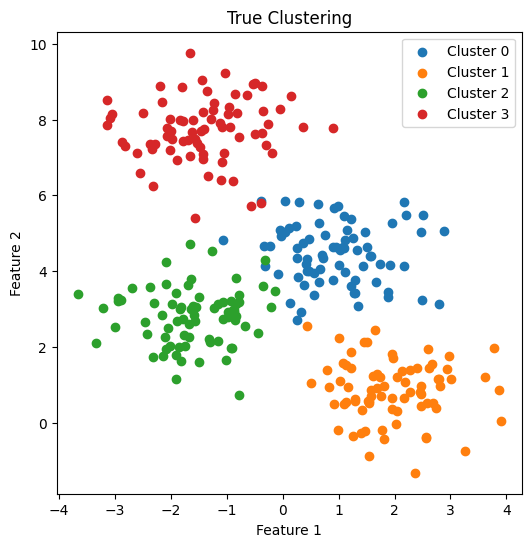

In [20]:
# Step 3: 結果の可視化
def plot_clustering(data, labels, centroids=None, title=''):
    fig, ax = plt.subplots(figsize=(6, 6))
    for cluster in np.unique(labels):
        cluster_points = data[labels == cluster]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")
    
    if centroids is not None:
        ax.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroids')
    
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()
    
# データの可視化
plot_clustering(data, true_labels, title='True Clustering')

データは実際には色分けされているわけではありませんが，`make_blob()` 関数でデータを作成していて，適当なクラスタからデータを生成しているので，各データに色をつけて提示しています．

もちろん，機械学習でクラスタリングするときは，各クラスタの情報は提示しません．

## 1. K-means 法によるクラスタリング

K-means 法は自前で組んでもいいですが、scikit-learn に実装されているので、それを使います。
手法としては `sklearn.cluster` モジュールの中にある `KMeans` クラスを用います．

コンストラクタにわたす初期値としては

- `n_clusters`: K平均法のクラスタ数 K の指定
- `random_state`: 乱数の初期シード（クラスタ中心を乱数に従ってばらまくので指定）

を指定したインスタンスを作成し，このインスタンスに対して `fit_predict()` 関数を用いることで実行します．

In [21]:
from sklearn.cluster import KMeans

# K-meansクラスタリングの適用
kmeans = KMeans(n_clusters=n_clusters, random_state=0) # クラスタ数を指定してKMeansクラスのインスタンスを作成
predicted_labels = kmeans.fit_predict(data) # クラスタリングを実行


これだけだと，どうクラスタリングされたかわからないので，描画します．
クラスタ情報は，`KMeans` クラスのインスタンス(上記例では `kmeans`) の属性である，`cluster_centers_` に入れられます．なので，この情報を用いて色付けを行います．

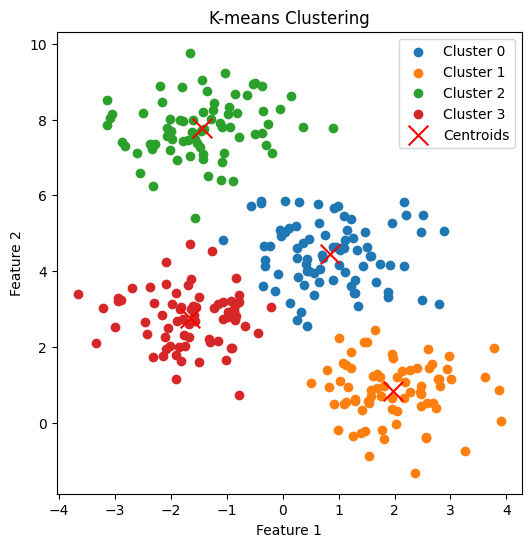

In [22]:
# クラスタリング結果のプロット．先ほど定義した plot_clustering を利用
plot_clustering(data, predicted_labels, centroids=kmeans.cluster_centers_, title="K-means Clustering")


微妙にずれてはいますが，大筋予想した通りに動いています．

クラスタリングの良し悪しを測る場合，簡単な方法としてクラスタにどのくらいデータが集まっているか（クラスタ内凝集度 Within Cluster Sum of Squares: WCSS）を測る方法があります．
この値は，scikit-learn の `KMeans` クラスの `inertia_` に記録されています．


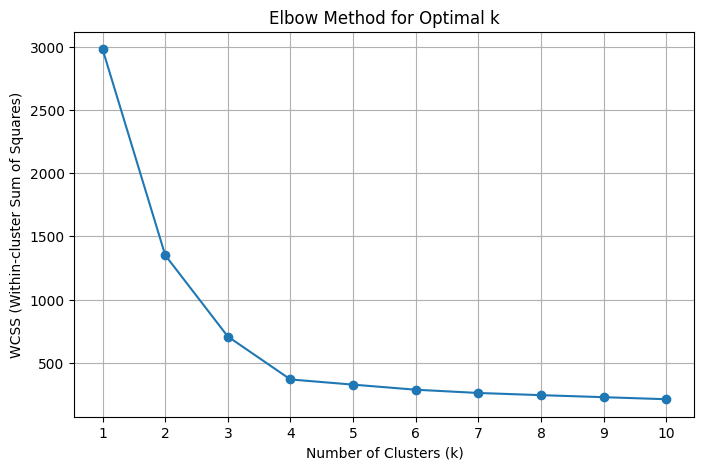

In [23]:
# WCSSの計算
wcss = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

# プロット
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o')
plt.xticks(k_values)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()

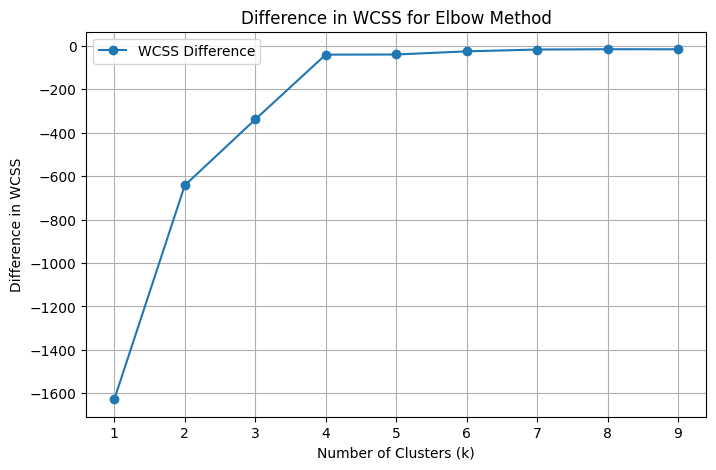

In [25]:
# 差分の計算
wcss_diff = np.diff(wcss)

# 差分プロット
plt.figure(figsize=(8, 5))
plt.plot(k_values[:-1], wcss_diff, marker='o', label='WCSS Difference')
plt.xticks(k_values[:-1])
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Difference in WCSS')
plt.title('Difference in WCSS for Elbow Method')
plt.grid()
plt.legend()
plt.show()

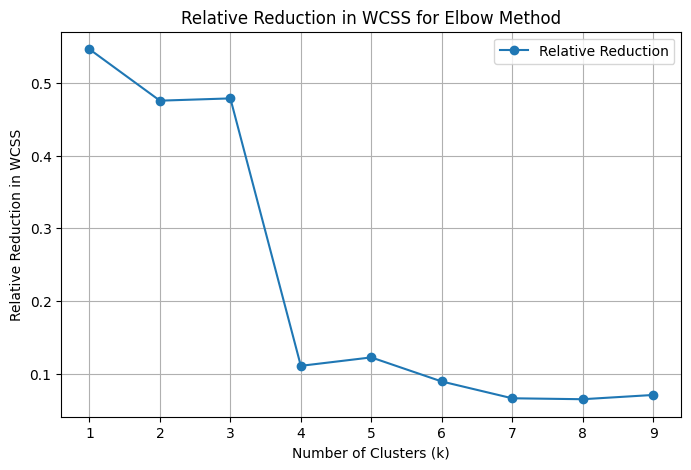

In [24]:
relative_reduction = -np.diff(wcss) / np.array(wcss[:-1])

# 相対減少率プロット
plt.figure(figsize=(8, 5))
plt.plot(k_values[:-1], relative_reduction, marker='o', label='Relative Reduction')
plt.xticks(k_values[:-1])
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Relative Reduction in WCSS')
plt.title('Relative Reduction in WCSS for Elbow Method')
plt.grid()
plt.legend()
plt.show()

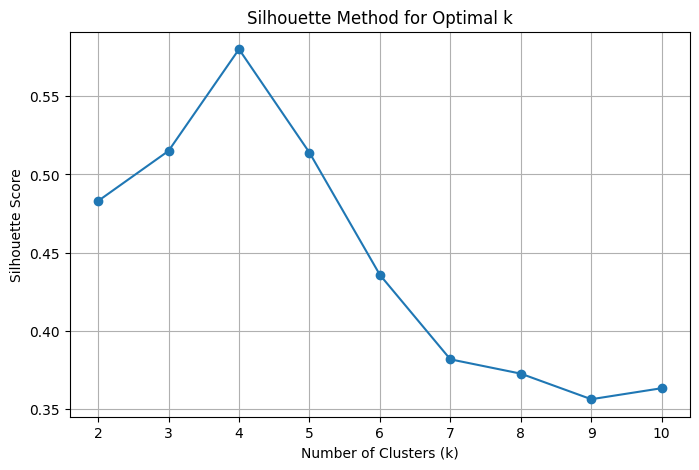

In [26]:
from sklearn.metrics import silhouette_score

# シルエットスコアの計算
silhouette_scores = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data)
    silhouette_scores.append(silhouette_score(data, labels))

# プロット
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xticks(k_values)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.grid()
plt.show()

In [ ]:
# 演習3 K-Means 法

1. クラスタ数の違いによるシルエットスコア，WCSSの比較
2. シードの違いによるクラスタ数の比較

